In [ ]:
import openmc
import numpy as np
import os
import matplotlib.pyplot as plt
#os.system('export OPENMC_CROSS_SECTIONS="/storage/work/ajg7072/NUCE_403/endf/cross_sections.xml"')
#os.environ["OPENMC_CROSS_SECTIONS"] = "/storage/work/ajg7072/NUCE_403/endf/cross_sections.xml"

## Defining materials

# This "fuel" is the classic UO2 and I added gadolinium as a burnable poison just to experiment (very sensitive to gad concentration). 
# I doubt that this is right so it will have to be revised. It should be a mix of UO2 and Gd2O3
fuel = openmc.Material(name='uo2_gad') 
fuel.add_nuclide('U235', 0.18) 
fuel.add_nuclide('U238', 0.82)
fuel.add_element('Gd', 0.00075)
fuel.add_nuclide('O16', 5) 
fuel.set_density('g/cm3', 11.5) 

cladding = openmc.Material(name='zircaloy4') 
cladding.add_element('Zr',0.98) 
cladding.add_element('Sn',0.015) 
cladding.add_element('Fe',0.002) 
cladding.add_element('Cr',0.001) 
cladding.add_element('O',0.001) 
cladding.add_element('Hf', 0.001) 
cladding.set_density('g/cm3', 6.34) 

water = openmc.Material(name='h2o') 
water.add_nuclide('H1', 2.0) 
water.add_nuclide('O16', 1.0) 
water.set_density('g/cm3', 1.0) 
water.add_s_alpha_beta('c_H_in_H2O')

ctrl_rod = openmc.Material(name='bc4')
ctrl_rod.add_nuclide('B10', 0.7)
ctrl_rod.add_nuclide('B11', 0.3)
ctrl_rod.add_nuclide('C12', 4)
ctrl_rod.set_density('g/cm3', 2.5)

rpv = openmc.Material(name='stainless_steel')   #Not really following any stablished "named" materials, just went with an approximation
rpv.add_element('Fe', 0.7)
rpv.add_element('Cr', 0.2)
rpv.add_element('Ni', 0.08)
rpv.add_element('Mn', 0.01)
rpv.add_element('C', 0.01)
rpv.set_density('g/cm3', 7.6)

mats = openmc.Materials([fuel, cladding, water, ctrl_rod, rpv]) 
mats.cross_sections = "/mnt/c/Users/djamo/Desktop/OpenMC XS/endfb-viii.0-hdf5/cross_sections.xml"
mats.export_to_xml() 

## Defining geometry


# First defining dimensions and limiting surfaces for fuel, clad, and (when we had them) control rods
# Specify boundary conditions only to the exterior surfaces
# Changed the radius of the pellet to be more realistic (1 whole cm was a lot)

H_core = 225
R_core = 150
r_uo2=0.6
cyl_uo2 = openmc.ZCylinder(r=0.6)
cyl_clad = openmc.ZCylinder(r=0.62)
cyl_ctrl = openmc.ZCylinder(r=0.62)
cyl_no_ctrl = openmc.ZCylinder(r=0.62)
cyl_rpv_i = openmc.ZCylinder(r=R_core-10)
cyl_rpv_o = openmc.ZCylinder(r=R_core, boundary_type='vacuum')
z_max = openmc.ZPlane(z0=H_core, boundary_type='vacuum')
z_min = openmc.ZPlane(z0=-H_core, boundary_type='vacuum')

# regions
uo2_region = -cyl_uo2 & -z_max & +z_min
clad_region = +cyl_uo2 & -cyl_clad & -z_max & +z_min
water_region = +cyl_clad & -z_max & +z_min
ctrl_region = -cyl_ctrl & -z_max & +z_min
no_ctrl_region = -cyl_no_ctrl & -z_max & +z_min
water_ctrl_region = +cyl_ctrl & -z_max & +z_min
water_no_ctrl_region = +cyl_no_ctrl & -z_max & +z_min
rpv_region = +cyl_rpv_i & -cyl_rpv_o & -z_max & +z_min
water_rod_region = -cyl_ctrl & -z_max & +z_min

# cells
uo2_cell = openmc.Cell(name='fuel')
uo2_cell.region = uo2_region
uo2_cell.fill = fuel

clad_cell = openmc.Cell(name='cladding')
clad_cell.region = clad_region
clad_cell.fill = cladding

ctrl_cell = openmc.Cell(name='ctrl_rod')
ctrl_cell.region = ctrl_region
ctrl_cell.fill = ctrl_rod

no_ctrl_cell = openmc.Cell(name='no_ctrl_rod')
no_ctrl_cell.region = no_ctrl_region
no_ctrl_cell.fill = water

water_cell = openmc.Cell(name='water')
water_cell.region = water_region
water_cell.fill = water

water_cell_ctrl = openmc.Cell(name='water_ctrl')        # This might be unnecessary, essentially the same as the water cell
water_cell_ctrl.region = water_ctrl_region
water_cell_ctrl.fill = water

water_cell_no_ctrl = openmc.Cell(name='water_no_ctrl')        # This might be unnecessary, essentially the same as the water cell
water_cell_no_ctrl.region = water_no_ctrl_region
water_cell_no_ctrl.fill = water

rpv_cell = openmc.Cell(name='vessel')
rpv_cell.region = rpv_region
rpv_cell.fill = rpv

water_rod_cell = openmc.Cell(name='water_rod_uncontrolled')
water_rod_cell.region = water_rod_region
water_rod_cell.fill = water

# universes, the outer universe i see it as a safety net so that everything is covered

fuel_universe = openmc.Universe(cells=[uo2_cell, clad_cell, water_cell])
ctrl_rod_universe = openmc.Universe(cells=[ctrl_cell, water_cell_ctrl])
outer_universe = openmc.Universe(cells=[openmc.Cell(fill=water)])
no_ctrl_rod_universe = openmc.Universe(cells=[no_ctrl_cell, water_cell_no_ctrl])

lat = openmc.HexLattice()    # this is the lattice of the fuel pins arranged into 3 rings to form the assembly
lat.center = (0., 0.)
lat.pitch = (4.6,)           # i picked this number just to make it fit, no calculations. 
# Changing this number affects k-eff a lot. Could make it smaller and even fit one more assembly ring
lat.outer = outer_universe

outer_ring = [fuel_universe] * 12
middle_ring = [fuel_universe] * 6
inner_ring = [no_ctrl_rod_universe]         # this used to be ctrl_rod_universe, but since we need burnable poisons it needs to be uncontrolled
lat.universes = [outer_ring, middle_ring, inner_ring] # this completely defines the lattice structure


# this defines the fuel assembly cell so that it can be stacked
a = 2.75 * lat.pitch[0]  # formula
outer_boundary = openmc.model.hexagonal_prism(edge_length=a, orientation='y')
main_cell = openmc.Cell(fill=lat, region=outer_boundary & -z_max & +z_min)

assembly_univ = openmc.Universe(cells=[main_cell]) #just "converting" the cell into a universe so that it can be merged

core_lat = openmc.HexLattice()
core_lat.center = (0.,0.)
core_lat.pitch = (np.sqrt(3)*a-0.8,)  # the sqrt3*a is the formula, then manually adjusting it so that it looks homogeneous
core_lat.outer = outer_universe # used the same outer as when defining the assemblies, it does not matter
core_lat.orientation = 'x' # these orientations are either x or y. I just change them until they agree lol

ring_1 = [assembly_univ]
ring_2 = [assembly_univ] * 6
ring_3 = [assembly_univ] * 12
ring_4 = [assembly_univ] * 18
ring_5 = [assembly_univ] * 24
ring_6 = [assembly_univ] * 30
ring_7 = [assembly_univ] * 36
core_lat.universes = [ring_7, ring_6, ring_5, ring_4, ring_3, ring_2, ring_1]

# only the "water" of the core, no pressure vessel
whole_core_cell = openmc.Cell(fill=core_lat, region=-cyl_rpv_i & -z_max & +z_min)

geom = openmc.Geometry([whole_core_cell, rpv_cell]) #pressure vessel added here
geom.export_to_xml()

#p.to_ipython_image()
# failed trial run for tallies. We don't really need them anymore but just in case i left them here

r_grid_num = np.linspace(0,R_core,15)
z_grid_num = np.linspace(-H_core,H_core, 50)
phi_grid_num = np.array([0, 2*np.pi])

mesh = openmc.CylindricalMesh(
    r_grid = r_grid_num,
    z_grid = z_grid_num,
    phi_grid = phi_grid_num,
    origin = (0.0,0.0,0.0)
)

mesh_filter = openmc.MeshFilter(mesh)

flux_tally = openmc.Tally(name='raw_flux')
flux_tally.filter = [mesh_filter]
flux_tally.scores = ['flux']

tallies = openmc.Tallies([flux_tally])
#tallies.export_to_xml()


###############################################################################
#                     Set volumes of depletable materials
###############################################################################

# Set material volume for depletion. For 2D simulations, this should be an area.
#uo2.volume = pi * cyl_uo2.r**2 *H_core*2286   #whole core, with 2286 pins

###############################################################################
#                     Transport calculation settings
###############################################################################

# Instantiate a Settings object, set all runtime parameters, and export to XML
settings = openmc.Settings()
settings.batches = 500
settings.inactive = 10
settings.particles = 200000

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.62992, -0.62992, -1, 0.62992, 0.62992, 1]   #Marked for further discu.
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:])
settings.source = openmc.IndependentSource(
    space=uniform_dist, constraints={'fissionable': True})

###############################################################################
#                   Initialize and run depletion calculation
############################################################################
 # Depletion Cell
import openmc.deplete
fuel.volume = np.pi * cyl_uo2.r**2 *H_core*2286   #2286 pins
chain = openmc.deplete.Chain.from_xml("/mnt/c/Users/djamo/Desktop/OpenMC XS/endfb-viii.0-hdf5/chain_simple.xml")
model = openmc.Model(geometry=geom, materials=mats, settings=settings)
operator = openmc.deplete.CoupledOperator(
    model,
    "/mnt/c/Users/djamo/Desktop/OpenMC XS/endfb-viii.0-hdf5/chain_simple.xml",
)

power = 20e6 #W
time_steps = [0.1, 0.2, 0.4, 0.8,1.6,2.5,5,
             10,20,40,80,160,320,640,1280,2560,5120]  # test only
integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power, timestep_units='d') # also better options available
integrator.integrate()


openmc.run(threads=4) #aiden's contribution

/home/djamo/miniconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "
[DjamondsLaptop:81769] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.DjamondsLaptop.1000/jf.0/4002676736/shared_mem_cuda_pool.DjamondsLaptop could be created.
[DjamondsLaptop:81769] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading H1 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/H1.h5
 Reading B10 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/B10.h5
 Reading B11 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/B11.h5
 Reading C12 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/C12.h5
 Reading C13 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/C13.h5
 Reading Mn55 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/Mn55.h5
 Reading Ni58 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/Ni58.h5
 Reading Ni60 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/Ni60.h5
 Reading Ni61 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/Ni61.h5
 Reading Ni62 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/Ni62.h5
 Reading Ni64 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/Ni64.h5
 Reading c_

 Reading Xe135 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/Xe135.h5
 Reading Xe136 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/Xe136.h5
 Reading Cs135 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/Cs135.h5
 Reading U234 from /mnt/c/Users/djamo/Desktop/OpenMC
 XS/endfb-viii.0-hdf5/neutron/U234.h5


In [ ]:

import numpy as np 

import os 

import math 

#os.environ["PATH"] = "/storage/work/ugh5000/.conda/envs/openmc/bin:" + os.environ["PATH"] 

import openmc 

#os.environ["OPENMC_CROSS_SECTIONS"] = "/storage/work/ugh5000/openmc_xs/endfb-viii.0-hdf5/cross_sections.xml"

#os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"



## Defining materials



# This "fuel" is the classic UO2 and I added gadolinium as a burnable poison just to experiment (very sensitive to gad concentration). 

# I doubt that this is right so it will have to be revised. It should be a mix of UO2 and Gd2O3

fuel = openmc.Material(name='uo2_gad') 

fuel.add_nuclide('U235', 0.18) 

fuel.add_nuclide('U238', 0.82)

fuel.add_element('Gd', 0.00075)

fuel.add_nuclide('O16', 5) 

fuel.set_density('g/cm3', 11.5) 



cladding = openmc.Material(name='zircaloy4') 

cladding.add_element('Zr',0.98) 

cladding.add_element('Sn',0.015) 

cladding.add_element('Fe',0.002) 

cladding.add_element('Cr',0.001) 

cladding.add_element('O',0.001) 

cladding.add_element('Hf', 0.001) 

cladding.set_density('g/cm3', 6.34) 



water = openmc.Material(name='h2o') 

water.add_nuclide('H1', 2.0) 

water.add_nuclide('O16', 1.0) 

water.set_density('g/cm3', 1.0) 

water.add_s_alpha_beta('c_H_in_H2O')



ctrl_rod = openmc.Material(name='bc4')

ctrl_rod.add_nuclide('B10', 0.7)

ctrl_rod.add_nuclide('B11', 0.3)

ctrl_rod.add_nuclide('C12', 4)

ctrl_rod.set_density('g/cm3', 2.5)



rpv = openmc.Material(name='stainless_steel')   #Not really following any stablished "named" materials, just went with an approximation

rpv.add_element('Fe', 0.7)

rpv.add_element('Cr', 0.2)

rpv.add_element('Ni', 0.08)

rpv.add_element('Mn', 0.01)

rpv.add_element('C', 0.01)

rpv.set_density('g/cm3', 7.6)



mats = openmc.Materials([fuel, cladding, water, ctrl_rod, rpv]) 

mats.cross_sections = "/mnt/c/Users/djamo/Desktop/OpenMC XS/endfb-viii.0-hdf5/chain_simple.xml"

mats.export_to_xml() 







## Defining geometry





# First defining dimensions and limiting surfaces for fuel, clad, and (when we had them) control rods

# Specify boundary conditions only to the exterior surfaces

# Changed the radius of the pellet to be more realistic (1 whole cm was a lot)



H_core = 225

R_core = 150

cyl_uo2 = openmc.ZCylinder(r=0.6)

cyl_clad = openmc.ZCylinder(r=0.62)

cyl_ctrl = openmc.ZCylinder(r=0.62)

cyl_no_ctrl = openmc.ZCylinder(r=0.62)

cyl_rpv_i = openmc.ZCylinder(r=R_core-10)

cyl_rpv_o = openmc.ZCylinder(r=R_core, boundary_type='vacuum')

z_max = openmc.ZPlane(z0=H_core, boundary_type='vacuum')

z_min = openmc.ZPlane(z0=-H_core, boundary_type='vacuum')



# regions

uo2_region = -cyl_uo2 & -z_max & +z_min

clad_region = +cyl_uo2 & -cyl_clad & -z_max & +z_min

water_region = +cyl_clad & -z_max & +z_min

ctrl_region = -cyl_ctrl & -z_max & +z_min

no_ctrl_region = -cyl_no_ctrl & -z_max & +z_min

water_ctrl_region = +cyl_ctrl & -z_max & +z_min

water_no_ctrl_region = +cyl_no_ctrl & -z_max & +z_min

rpv_region = +cyl_rpv_i & -cyl_rpv_o & -z_max & +z_min

water_rod_region = -cyl_ctrl & -z_max & +z_min



# cells

uo2_cell = openmc.Cell(name='fuel')

uo2_cell.region = uo2_region

uo2_cell.fill = fuel



clad_cell = openmc.Cell(name='cladding')

clad_cell.region = clad_region

clad_cell.fill = cladding



ctrl_cell = openmc.Cell(name='ctrl_rod')

ctrl_cell.region = ctrl_region

ctrl_cell.fill = ctrl_rod



no_ctrl_cell = openmc.Cell(name='no_ctrl_rod')

no_ctrl_cell.region = no_ctrl_region

no_ctrl_cell.fill = water



water_cell = openmc.Cell(name='water')

water_cell.region = water_region

water_cell.fill = water



water_cell_ctrl = openmc.Cell(name='water_ctrl')        # This might be unnecessary, essentially the same as the water cell

water_cell_ctrl.region = water_ctrl_region

water_cell_ctrl.fill = water



water_cell_no_ctrl = openmc.Cell(name='water_no_ctrl')        # This might be unnecessary, essentially the same as the water cell

water_cell_no_ctrl.region = water_no_ctrl_region

water_cell_no_ctrl.fill = water



rpv_cell = openmc.Cell(name='vessel')

rpv_cell.region = rpv_region

rpv_cell.fill = rpv



water_rod_cell = openmc.Cell(name='water_rod_uncontrolled')

water_rod_cell.region = water_rod_region

water_rod_cell.fill = water



# universes, the outer universe i see it as a safety net so that everything is covered



fuel_universe = openmc.Universe(cells=[uo2_cell, clad_cell, water_cell])

ctrl_rod_universe = openmc.Universe(cells=[ctrl_cell, water_cell_ctrl])

outer_universe = openmc.Universe(cells=[openmc.Cell(fill=water)])

no_ctrl_rod_universe = openmc.Universe(cells=[no_ctrl_cell, water_cell_no_ctrl])



lat = openmc.HexLattice()    # this is the lattice of the fuel pins arranged into 3 rings to form the assembly

lat.center = (0., 0.)

lat.pitch = (4.6,)           # i picked this number just to make it fit, no calculations. 

# Changing this number affects k-eff a lot. Could make it smaller and even fit one more assembly ring

lat.outer = outer_universe



outer_ring = [fuel_universe] * 12

middle_ring = [fuel_universe] * 6

inner_ring = [no_ctrl_rod_universe]         # this used to be ctrl_rod_universe, but since we need burnable poisons it needs to be uncontrolled

lat.universes = [outer_ring, middle_ring, inner_ring] # this completely defines the lattice structure





# this defines the fuel assembly cell so that it can be stacked

a = 2.75 * lat.pitch[0]  # formula

outer_boundary = openmc.model.hexagonal_prism(edge_length=a, orientation='y')

main_cell = openmc.Cell(fill=lat, region=outer_boundary & -z_max & +z_min)



assembly_univ = openmc.Universe(cells=[main_cell]) #just "converting" the cell into a universe so that it can be merged



core_lat = openmc.HexLattice()

core_lat.center = (0.,0.)

core_lat.pitch = (np.sqrt(3)*a-0.8,)  # the sqrt3*a is the formula, then manually adjusting it so that it looks homogeneous

core_lat.outer = outer_universe # used the same outer as when defining the assemblies, it does not matter

core_lat.orientation = 'x' # these orientations are either x or y. I just change them until they agree lol



ring_1 = [assembly_univ]

ring_2 = [assembly_univ] * 6

ring_3 = [assembly_univ] * 12

ring_4 = [assembly_univ] * 18

ring_5 = [assembly_univ] * 24

ring_6 = [assembly_univ] * 30

ring_7 = [assembly_univ] * 36

core_lat.universes = [ring_7, ring_6, ring_5, ring_4, ring_3, ring_2, ring_1]



# only the "water" of the core, no pressure vessel

whole_core_cell = openmc.Cell(fill=core_lat, region=-cyl_rpv_i & -z_max & +z_min)



geom = openmc.Geometry([whole_core_cell, rpv_cell]) #pressure vessel added here

geom.export_to_xml()

settings = openmc.Settings()

settings.batches = 500

settings.inactive = 10

settings.particles = 200000

settings.run_mode = 'eigenvalue'

settings.temperature = {'method': 'interpolation', 'tolerance' : 200,'range' : [1,1400]}

settings.export_to_xml()

for temp in np.linspace(373,973,11):

    for tempmod in np.linspace(373,973,11):

        fuel.temperature=temp

        cladding.temperature=temp

        water.temperature=tempmod


        mats.export_to_xml()

        openmc.run(threads=4)

        os.rename('statepoint.100.h5',f'{temp}_{tempmod}.h5')

        

Moderator temperatures found in files (K):
[373.0, 433.0, 493.0, 553.0, 613.0, 673.0, 733.0, 793.0, 853.0, 913.0, 973.0]

Requested T_mod ≈ 600.0 K; using closest available: 613.0 K

Data points used (T_fuel [K], ρ [pcm]):
     373.0   15099.122
     433.0   15187.940
     493.0   15206.975
     553.0   15332.752


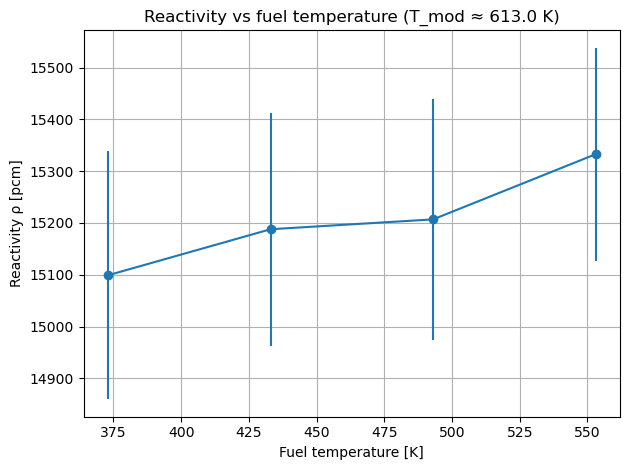


Fuel temperature coefficient at T_mod ≈ 613.0 K:
  alpha_F ≈ 1.200 pcm/K


In [8]:
import os
import glob
import numpy as np
import openmc
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 0) Directory with statepoint .h5 files
# ---------------------------------------------------------
STATEPOINT_DIR = "/mnt/c/Users/djamo/Downloads/tempdistri"

# If you want a specific moderator temperature, put it here.
# The script will pick the closest available value in the files.
DESIRED_T_MOD = 600  # K (approximate value; script snaps to nearest)

# ---------------------------------------------------------
# 1) Discover available (T_fuel, T_mod) pairs from filenames
# ---------------------------------------------------------
pattern = os.path.join(STATEPOINT_DIR, "*.h5")
statepoint_files = glob.glob(pattern)

if len(statepoint_files) == 0:
    raise RuntimeError(f"No .h5 files found in {STATEPOINT_DIR}")

pairs = set()
for fname in statepoint_files:
    base = os.path.splitext(os.path.basename(fname))[0]  # e.g. "373.0_573.0"
    try:
        T_fuel, T_mod = map(float, base.split("_"))
        pairs.add((T_fuel, T_mod))
    except ValueError:
        # Skip files whose names don't match "fuel_mod.h5" pattern
        continue

if len(pairs) == 0:
    raise RuntimeError("No valid 'Tfuel_Tmod.h5' filenames found in directory.")

all_Tmod = sorted({T_mod for (_, T_mod) in pairs})

print("Moderator temperatures found in files (K):")
print(all_Tmod)

# Choose moderator temperature closest to DESIRED_T_MOD
actual_T_mod = min(all_Tmod, key=lambda t: abs(t - DESIRED_T_MOD))
print(f"\nRequested T_mod ≈ {DESIRED_T_MOD:.1f} K; using closest available: {actual_T_mod:.1f} K\n")

# ---------------------------------------------------------
# 2) Collect ρ(T_fuel) data for this moderator temperature
# ---------------------------------------------------------
fuel_temps = []
rho_pcm = []
rho_pcm_err = []

for fname in statepoint_files:
    base = os.path.splitext(os.path.basename(fname))[0]
    try:
        T_fuel, T_mod = map(float, base.split("_"))
    except ValueError:
        continue

    # Select only points with this moderator temperature
    if abs(T_mod - actual_T_mod) > 1e-6:
        continue

    sp = openmc.StatePoint(fname)

    # Handle both newer and older OpenMC APIs
    try:
        # Newer: sp.keff is an uncertainties.UFloat
        keff_var = sp.keff
        keff_mean = keff_var.nominal_value
        keff_std = keff_var.std_dev
    except AttributeError:
        # Older: sp.k_combined is [mean, std]
        keff_mean, keff_std = sp.k_combined

    # Reactivity and uncertainty
    rho = (keff_mean - 1.0) / keff_mean          # dimensionless
    rho_err = keff_std / (keff_mean**2)          # dρ/dk = 1/k^2

    fuel_temps.append(T_fuel)
    rho_pcm.append(rho * 1.0e5)                  # pcm
    rho_pcm_err.append(rho_err * 1.0e5)          # pcm

fuel_temps = np.array(fuel_temps)
rho_pcm = np.array(rho_pcm)
rho_pcm_err = np.array(rho_pcm_err)

if fuel_temps.size == 0:
    raise RuntimeError(
        f"No data points found for moderator temperature {actual_T_mod:.1f} K."
        " Check that filenames are 'Tfuel_Tmod.h5' and that the directory is correct."
    )

# Sort by fuel temperature for a clean plot / fit
idx = np.argsort(fuel_temps)
fuel_temps = fuel_temps[idx]
rho_pcm = rho_pcm[idx]
rho_pcm_err = rho_pcm_err[idx]

print("Data points used (T_fuel [K], ρ [pcm]):")
for T_f, r in zip(fuel_temps, rho_pcm):
    print(f"  {T_f:8.1f}  {r: .3f}")

# ---------------------------------------------------------
# 3) Plot reactivity vs fuel temperature
# ---------------------------------------------------------
plt.errorbar(fuel_temps, rho_pcm, yerr=rho_pcm_err, fmt="o-")
plt.xlabel("Fuel temperature [K]")
plt.ylabel("Reactivity ρ [pcm]")
plt.title(f"Reactivity vs fuel temperature (T_mod ≈ {actual_T_mod:.1f} K)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4) Linear fit to get temperature coefficient
# ---------------------------------------------------------
if fuel_temps.size < 2:
    raise RuntimeError("Need at least two temperatures to fit a slope.")

coeffs = np.polyfit(fuel_temps, rho_pcm, 1)  # ρ = a*T + b
alpha_F = coeffs[0]                          # pcm/K

print(f"\nFuel temperature coefficient at T_mod ≈ {actual_T_mod:.1f} K:")
print(f"  alpha_F ≈ {alpha_F:.3f} pcm/K")


Isothermal data points (T [K], ρ [pcm]):
     373.0   5987.218
     433.0   8636.194
     493.0   11298.391
     553.0   12972.948


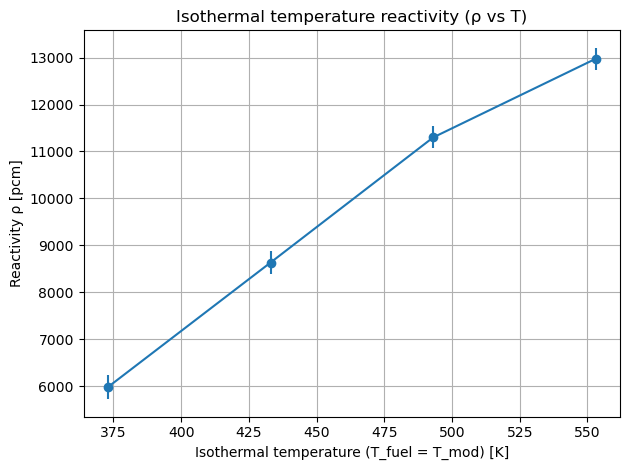


Isothermal temperature reactivity coefficient (T_fuel = T_mod):
  alpha_T ≈ 39.366 pcm/K


In [9]:
import os
import glob
import numpy as np
import openmc
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 0) Directory with statepoint .h5 files
# ---------------------------------------------------------
STATEPOINT_DIR = "/mnt/c/Users/djamo/Downloads/tempdistri"

# Tolerance to regard T_fuel and T_mod as "equal"
DIAGONAL_TOL = 1e-6  # K

# ---------------------------------------------------------
# 1) Collect isothermal points: T_fuel ≈ T_mod
# ---------------------------------------------------------
pattern = os.path.join(STATEPOINT_DIR, "*.h5")
statepoint_files = glob.glob(pattern)

if len(statepoint_files) == 0:
    raise RuntimeError(f"No .h5 files found in {STATEPOINT_DIR}")

iso_temps = []
rho_pcm = []
rho_pcm_err = []

for fname in statepoint_files:
    base = os.path.splitext(os.path.basename(fname))[0]  # e.g. "373.0_373.0"
    try:
        T_fuel, T_mod = map(float, base.split("_"))
    except ValueError:
        # Skip any file that doesn't match "Tfuel_Tmod.h5"
        continue

    # Keep only points where fuel and moderator temperatures are equal
    if abs(T_fuel - T_mod) > DIAGONAL_TOL:
        continue

    # Common temperature for this isothermal point
    T_iso = T_fuel  # == T_mod within tolerance

    # Open the statepoint and get k_eff
    sp = openmc.StatePoint(fname)

    # Handle both newer and older OpenMC APIs
    try:
        # Newer: sp.keff is an uncertainties.UFloat
        keff_var = sp.keff
        keff_mean = keff_var.nominal_value
        keff_std = keff_var.std_dev
    except AttributeError:
        # Older: sp.k_combined is [mean, std]
        keff_mean, keff_std = sp.k_combined

    # Reactivity and its uncertainty
    # ρ = (k - 1)/k; dρ/dk = 1/k^2
    rho = (keff_mean - 1.0) / keff_mean         # dimensionless
    rho_err = keff_std / (keff_mean**2)         # dimensionless

    iso_temps.append(T_iso)
    rho_pcm.append(rho * 1.0e5)                 # pcm
    rho_pcm_err.append(rho_err * 1.0e5)         # pcm

iso_temps = np.array(iso_temps)
rho_pcm = np.array(rho_pcm)
rho_pcm_err = np.array(rho_pcm_err)

if iso_temps.size == 0:
    raise RuntimeError(
        "No isothermal points found (T_fuel ≈ T_mod). "
        "Check that filenames are 'Tfuel_Tmod.h5' and that some runs used "
        "the same fuel and moderator temperatures."
    )

# Sort by temperature for cleaner plots and fits
idx = np.argsort(iso_temps)
iso_temps = iso_temps[idx]
rho_pcm = rho_pcm[idx]
rho_pcm_err = rho_pcm_err[idx]

print("Isothermal data points (T [K], ρ [pcm]):")
for T, r in zip(iso_temps, rho_pcm):
    print(f"  {T:8.1f}  {r: .3f}")

# ---------------------------------------------------------
# 2) Plot reactivity vs isothermal temperature
# ---------------------------------------------------------
plt.errorbar(iso_temps, rho_pcm, yerr=rho_pcm_err, fmt="o-")
plt.xlabel("Isothermal temperature (T_fuel = T_mod) [K]")
plt.ylabel("Reactivity ρ [pcm]")
plt.title("Isothermal temperature reactivity (ρ vs T)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 3) Linear fit to get isothermal temperature coefficient
# ---------------------------------------------------------
if iso_temps.size < 2:
    raise RuntimeError("Need at least two temperatures to fit a slope.")

coeffs = np.polyfit(iso_temps, rho_pcm, 1)  # ρ = a*T + b
alpha_iso = coeffs[0]                        # pcm/K

print("\nIsothermal temperature reactivity coefficient (T_fuel = T_mod):")
print(f"  alpha_T ≈ {alpha_iso:.3f} pcm/K")
